In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader


load and prepare the data

In [3]:
LABEL_DIR = '/home/kuba/Documents/data/raw/face-detection-dataset/labels/train'
IMG_DIR = '/home/kuba/Documents/data/raw/face-detection-dataset/images/train'

with open('/home/kuba/projects/swvl/week01/single_face_train.txt', 'r') as file_names:
    names = file_names.readlines()
    train_img_paths = [ IMG_DIR + "/" + name.strip() + ".jpg" for name in names]
    train_label_paths = [ LABEL_DIR + "/" + name.strip() + ".txt" for name in names]


In [4]:
def process_and_pad_data(img_paths, label_paths, target_size=(224, 224)):
    image_tensors = []
    bboxes = []

    raw_imgs = []
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda t: t/255),  # Scale pixel values to 0..1
        transforms.Resize(target_size, antialias=True),  # Resize all images to same dimensions
    ])

    transform_raw = transforms.Compose([
        transforms.ToTensor()
    ])

    for f_img, f_label in tqdm(list(zip(img_paths, label_paths))):
        image = Image.open(f_img)
        raw_img = transform_raw(image)
        raw_imgs.append(raw_img)
        img_tensor = transform(image)
        if img_tensor.size()[0] == 1:
            img_tensor = img_tensor.repeat(3, 1, 1)

        
        with open(f_label, 'r') as f:
            label = f.readline().strip()
            bbox = torch.tensor([float(x) for x in label.split()])[1:]
        
        if img_tensor.size()[0] == 3:
            image_tensors.append(img_tensor)
            bboxes.append(bbox)
    
    
    X = torch.stack(image_tensors)  
    y = torch.stack(bboxes)
    # raw_imgs = torch.stack(raw_imgs)
    
    return X, y, raw_imgs

X, y, raw_imgs = process_and_pad_data(train_img_paths, train_label_paths)
print("Train images shape:", X.shape)
print("Train bboxes shape:", y.shape)

  0%|          | 0/5791 [00:00<?, ?it/s]

100%|██████████| 5791/5791 [00:53<00:00, 107.44it/s]


Train images shape: torch.Size([5789, 3, 224, 224])
Train bboxes shape: torch.Size([5789, 4])


In [51]:
train_dataset = TensorDataset(X[:100], y[:100])

In [74]:
train_loader = DataLoader(train_dataset, batch_size=2000)

init the model which is the same as in notebook 00 of week1

In [53]:
#same bacuise we go 3x3, 3x3, 3x3
class BasicBlockSame(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=stride, bias=False)
        self.bnorm0 = nn.BatchNorm2d(out_channels)

        self.conv1 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bnorm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bnorm2 = nn.BatchNorm2d(out_channels)

        self.shortcut  = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1, stride=stride)

    def forward(self, x):
        residual = x
        x = self.conv0(x)
        x = self.bnorm0(x)
        x = nn.functional.relu(x)

        x = self.conv1(x)
        x = self.bnorm1(x)
        x = nn.functional.relu(x)

        x = self.conv2(x)
        x = self.bnorm2(x)

        x += self.shortcut(residual)
        x = nn.functional.relu(x)
        return x


#varying bacuise we go 3x3, 1x1, 3x3
class BasicBlockVarying(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1 ):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=stride, bias=False)
        self.bnorm0 = nn.BatchNorm2d(out_channels)

        self.conv1 = nn.Conv2d(out_channels, out_channels, 1, bias=False)
        self.bnorm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bnorm2 = nn.BatchNorm2d(out_channels)

        self.shortcut  = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1, stride=stride)

    def forward(self, x):
        residual = x
        x = self.conv0(x)
        x = self.bnorm0(x)
        x = nn.functional.relu(x)

        x = self.conv1(x)
        x = self.bnorm1(x)
        x = nn.functional.relu(x)

        x = self.conv2(x)
        x = self.bnorm2(x)



        x += self.shortcut(residual)
        x = nn.functional.relu(x)
        return x


class SENBlock(nn.Module):
    def __init__(self, in_channels, r=16):
        super().__init__()
        self.sq = nn.AdaptiveAvgPool2d(1)
        self.fc0 = nn.Linear(in_channels, int(in_channels/r))
        self.fc1 = nn.Linear(int(in_channels/r), in_channels)

    def forward(self, x):
        residual = x
        batch_size, channels, _, _ = residual.size()
        x = self.sq(x).squeeze()
        x = self.fc0(x)
        x = nn.functional.relu(x)

        x = self.fc1(x)
        x = nn.functional.sigmoid(x).view(batch_size, channels, 1, 1)
        
        x = residual * x
        return x

In [9]:
class SenResNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.c0 = nn.Conv2d(3,32,3,padding=1)
        self.maxp = nn.MaxPool2d(2,2)
        self.resblock0 = BasicBlockSame(32,64, stride=2)
        self.resblock1 = BasicBlockSame(64,64)
        self.resblock2 = BasicBlockSame(64,64)
        self.sen0 = SENBlock(64)

        self.resblock3  = BasicBlockVarying(64,128, stride=2)
        self.resblock4  = BasicBlockVarying(128,128)
        self.resblock5  = BasicBlockVarying(128,128)
        self.resblock6  = BasicBlockVarying(128,128)
        self.sen1 = SENBlock(128)

        self.resblock7  = BasicBlockVarying(128,256, stride=2)
        self.resblock8  = BasicBlockVarying(256,256)
        self.resblock9  = BasicBlockVarying(256,256)
        self.resblock10  = BasicBlockVarying(256,256)
        self.resblock11  = BasicBlockVarying(256,256)
        self.resblock12  = BasicBlockVarying(256,256)
        self.sen2 = SENBlock(256)

        self.resblock13 = BasicBlockVarying(256,512, stride=2)
        self.resblock14  = BasicBlockVarying(512,512)
        self.resblock15 = BasicBlockVarying(512,512)

        self.c1 = nn.Conv2d(512, 1024, 3, padding=1 , stride=2)
        self.c2 = nn.Conv2d(1024, 512, 1, padding=1)
        self.gap0 = nn.AdaptiveAvgPool2d(1)
        self.fc0 = nn.Linear(512, 4)



    def forward(self, x):
        x = self.c0(x)
        x = self.maxp(x)

        x = self.resblock0.forward(x)
        x = self.resblock1.forward(x)
        x = self.resblock2.forward(x)
        x = self.sen0.forward(x)

        x = self.resblock3.forward(x)
        x = self.resblock4.forward(x)
        x = self.resblock5.forward(x)
        x = self.resblock6.forward(x)
        x = self.sen1.forward(x)

        x = self.resblock7.forward(x)
        x = self.resblock8.forward(x)
        x = self.resblock9.forward(x)
        x = self.resblock10.forward(x)
        x = self.resblock11.forward(x)
        x = self.resblock12.forward(x)
        x = self.sen2.forward(x)

        x = self.resblock13.forward(x)
        x = self.resblock14.forward(x)
        x = self.resblock15.forward(x)
        
        x = self.c1(x)
        x = self.c2(x)
        x = self.gap0(x).squeeze()
        x = self.fc0(x)


        return x

In [75]:
model = SenResNet()

In [76]:
# criterion = nn.MSELoss()
criterion = DIoULoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [77]:
lossi = []

In [82]:
device = 'cuda'
model = model.to(device)

In [ ]:
# criterion = IoULoss()

100%|██████████| 20/20 [00:03<00:00,  6.03it/s]


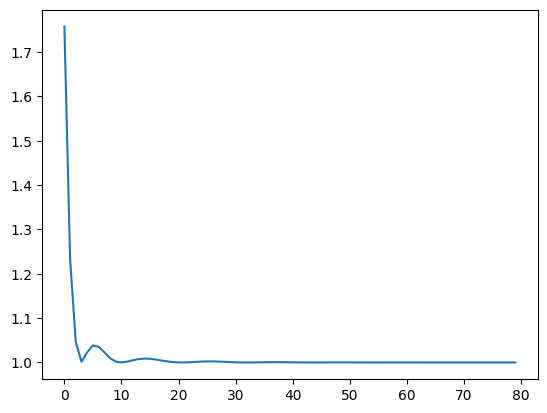

In [85]:
for epoch in tqdm(range(20)):
    loss_total = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_batch)
        loss = criterion(logits, y_batch.squeeze())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()

    lossi.append(loss_total / len(train_loader))

plt.plot(lossi)

([<matplotlib.lines.Line2D at 0x7bc6d6381de0>], '1.0001313686')

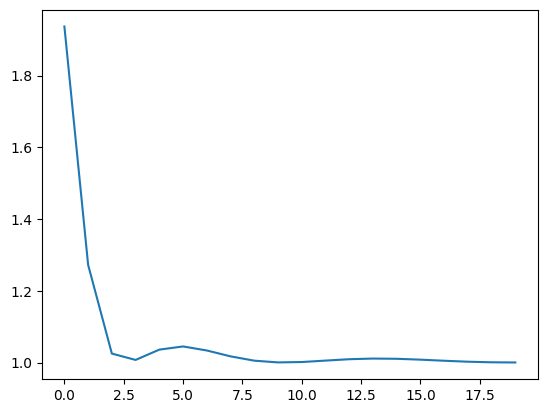

In [59]:
plt.plot(lossi), f"{lossi[-1]:.10f}"

In [70]:
def calculate_center_coordinates(im, bbox_pred):
    center_x_pxl = int(len(im[0]) * bbox_pred[0]) #img width * percent x
    center_y_pxl = int(len(im) * bbox_pred[1]) #img height * percent y
    return center_x_pxl, center_y_pxl

def calculate_box_dimensions(im, center_x_pxl, center_y_pxl, bbox_pred):
    half_width = int(len(im[0]) * (bbox_pred[2] / 2))
    half_height = int(len(im) * (bbox_pred[3] / 2))
    
    return {
        'y0': center_y_pxl + half_height,
        'y1': center_y_pxl - half_height,
        'x0': center_x_pxl + half_width,
        'x1': center_x_pxl - half_width,
        'xmin': center_x_pxl - half_width,
        'xmax': center_x_pxl + half_width,
        'ymin': center_y_pxl - half_height,
        'ymax': center_y_pxl + half_height
    }

def visualize_prediction(img_tensor, bbox_pred, epoch):
    im = img_tensor.squeeze(0).permute(1, 2, 0).numpy()
    
    center_x_pxl, center_y_pxl = calculate_center_coordinates(im, bbox_pred)
    coords = calculate_box_dimensions(im, center_x_pxl, center_y_pxl, bbox_pred)
    
    plt.imshow(im)
    plt.plot(center_x_pxl, center_y_pxl, 'ro')
    
    # horizontal lines
    plt.hlines(coords['y0'], xmin=coords['xmin'], xmax=coords['xmax'], colors='red')
    plt.hlines(coords['y1'], xmin=coords['xmin'], xmax=coords['xmax'], colors='red')
    
    # vertical lines
    plt.vlines(coords['x0'], coords['ymin'], coords['ymax'], colors='red')
    plt.vlines(coords['x1'], coords['ymin'], coords['ymax'], colors='red')
    
    plt.title(f'Epoch {epoch}')
    plt.show()

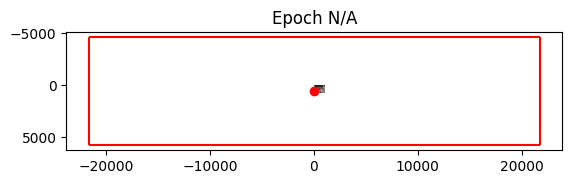

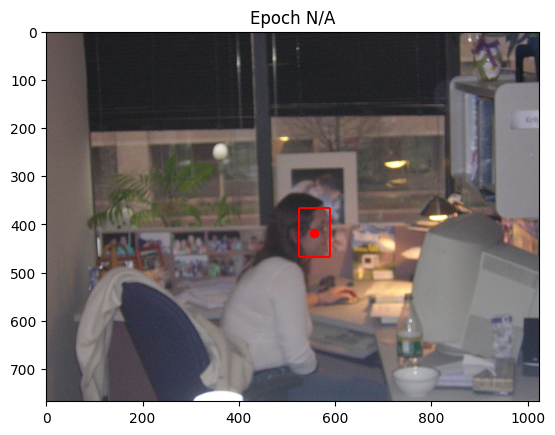

1.0001527070999146

In [80]:
img_num = 500
model = model.cpu()
logits = model(X[img_num].cpu().unsqueeze(dim=0))
visualize_prediction(raw_imgs[img_num], logits, 'N/A')
visualize_prediction(raw_imgs[img_num], y[img_num], 'N/A')

criterion(logits,y[img_num].cpu()).item()

In [19]:
logits.detach(), y[img_num]

(tensor([0.5214, 0.3777, 0.2548, 0.3245]),
 tensor([0.7164, 0.3832, 0.2131, 0.4030]))

In [20]:
torch.sum((logits.detach() - y[img_num].cpu()) ** 2) / logits.numel()


tensor(0.0115)

In [21]:
logits[..., 0]

tensor(0.5214, grad_fn=<SelectBackward0>)

In [22]:
from  torchvision.ops import box_iou

In [ ]:
def bbox_iou(pred, target):
    x1, y1 = pred[..., 0] - (pred[..., 2] / 2), pred[..., 1] + (pred[..., 3] / 2)
    x2, y2 = pred[..., 0] + (pred[..., 2] / 2), pred[..., 1] - (pred[..., 3] / 2)
    xyxy_pred = torch.stack([x1, y1, x2, y2], dim=-1)

    x1, y1 = target[..., 0] - (target[..., 2] / 2), target[..., 1] + (target[..., 3] / 2)
    x2, y2 = target[..., 0] + (target[..., 2] / 2), target[..., 1] - (target[..., 3] / 2)
    xyxy_target = torch.stack([x1, y1, x2, y2], dim=-1)


    x1 = torch.max(xyxy_pred[..., 0], xyxy_target[..., 0])
    y1 = torch.max(xyxy_pred[..., 1], xyxy_target[..., 1])
    x2 = torch.min(xyxy_pred[..., 2], xyxy_target[..., 2])
    y2 = torch.min(xyxy_pred[..., 3], xyxy_target[..., 3])

    intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)
    
    box1_area = (xyxy_pred[..., 2] - xyxy_pred[..., 0]) * (xyxy_pred[..., 3] - xyxy_pred[..., 1])
    box2_area = (xyxy_target[..., 2] - xyxy_target[..., 0]) * (xyxy_target[..., 3] - xyxy_target[..., 1])
    
    union = box1_area + box2_area - intersection
    
    iou = intersection / (union + 1e-7)  # Add small epsilon to avoid division by zero
    
    return iou

def diou_loss(pred, target):
    x1, y1 = pred[..., 0] - (pred[..., 2] / 2), pred[..., 1] + (pred[..., 3] / 2)
    x2, y2 = pred[..., 0] + (pred[..., 2] / 2), pred[..., 1] - (pred[..., 3] / 2)
    xyxy_pred = torch.stack([x1, y1, x2, y2], dim=-1)

    x1, y1 = target[..., 0] - (target[..., 2] / 2), target[..., 1] + (target[..., 3] / 2)
    x2, y2 = target[..., 0] + (target[..., 2] / 2), target[..., 1] - (target[..., 3] / 2)
    xyxy_target = torch.stack([x1, y1, x2, y2], dim=-1)

    iou = bbox_iou(pred, target)

    # Calculate center distance term
    pred_center_x = (xyxy_pred[..., 0] + xyxy_pred[..., 2]) / 2
    pred_center_y = (xyxy_pred[..., 1] + xyxy_pred[..., 3]) / 2
    
    target_center_x = (xyxy_target[..., 0] + xyxy_target[..., 2]) / 2
    target_center_y = (xyxy_target[..., 1] + xyxy_target[..., 3]) / 2
    
    center_distance = (pred_center_x - target_center_x) ** 2 + (pred_center_y - target_center_y) ** 2
    
    # Calculate diagonal length of smallest enclosing box
    enclose_left = torch.min(xyxy_pred[..., 0], xyxy_target[..., 0])
    enclose_top = torch.min(xyxy_pred[..., 1], xyxy_target[..., 1])
    enclose_right = torch.max(xyxy_pred[..., 2], xyxy_target[..., 2])
    enclose_bottom = torch.max(xyxy_pred[..., 3], xyxy_target[..., 3])
    
    enclose_diagonal = (enclose_right - enclose_left) ** 2 + (enclose_bottom - enclose_top) ** 2
    
    # Calculate DIoU
    diou = 1 - iou + (center_distance / (enclose_diagonal + 1e-7))
    
    return diou.mean()

In [ ]:
class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()

    def forward(self, pred, target):
        return bbox_iou(pred, target).mean()
    
class DIoULoss(nn.Module):
    def __init__(self):
        super(DIoULoss, self).__init__()

    def forward(self, pred, target):
        return diou_loss(pred, target)

In [44]:
# All the functions in this cell are expecting
# bounding boxes in the format (x1, y1, x2, y2)

def intersection_area(
    boxes1: BBCoordinates,
    boxes2: BBCoordinates,
) -> torch.Tensor:
    x1, y1, x2, y2 = boxes1
    x1g, y1g, x2g, y2g = boxes2

    x1i = torch.max(x1, x1g)
    y1i = torch.max(y1, y1g)
    x2i = torch.min(x2, x2g)
    y2i = torch.min(y2, y2g)

    return (x2i - x1i).clamp(0) * (y2i - y1i).clamp(0)


def union_area(
    boxes1: BBCoordinates,
    boxes2: BBCoordinates,
    inter: torch.Tensor,
) -> torch.Tensor:
    return boxes1.get_area() + boxes2.get_area() - inter


def convex_width_height(
    boxes1: BBCoordinates,
    boxes2: BBCoordinates,
) -> tuple[torch.Tensor, torch.Tensor]:
    x1, y1, x2, y2 = boxes1
    x1g, y1g, x2g, y2g = boxes2

    cw = torch.max(x2, x2g) - torch.min(x1, x1g)  # convex width
    ch = torch.max(y2, y2g) - torch.min(y1, y1g)  # convex height

    return cw, ch


def compute_iou(
    boxes1: torch.Tensor,
    boxes2: torch.Tensor,
    eps: float = 1e-7,
) -> torch.Tensor:
    x1, y1, x2, y2 = boxes1.unbind(dim=-1)
    x1g, y1g, x2g, y2g = boxes2.unbind(dim=-1)

    b1_coords = BBCoordinates(x1, y1, x2, y2)
    b2_coords = BBCoordinates(x1g, y1g, x2g, y2g)

    inter = intersection_area(b1_coords, b2_coords)
    union = union_area(b1_coords, b2_coords, inter)

    iou = inter / (union + eps)

    return iou


def iou_loss(
    boxes1: torch.Tensor,
    boxes2: torch.Tensor,
    eps: float = 1e-7,
    reduction: Literal["none", "mean", "sum"] = "none",
) -> torch.Tensor:
    iou = compute_iou(boxes1, boxes2, eps=eps)

    loss = 1 - iou

    if reduction == "sum":
        loss = loss.sum()
    elif reduction == "mean":
        loss = loss.mean()

    return loss


def giou_loss(
    boxes1: torch.Tensor,
    boxes2: torch.Tensor,
    eps: float = 1e-7,
    reduction: Literal["none", "mean", "sum"] = "none",
) -> torch.Tensor:
    x1, y1, x2, y2 = boxes1.unbind(dim=-1)
    x1g, y1g, x2g, y2g = boxes2.unbind(dim=-1)

    b1_coords = BBCoordinates(x1, y1, x2, y2)
    b2_coords = BBCoordinates(x1g, y1g, x2g, y2g)

    inter = intersection_area(b1_coords, b2_coords)
    union = union_area(b1_coords, b2_coords, inter)

    iou = inter / (union + eps)

    S = 1 - iou

    # compute the penality term

    cw, ch = convex_width_height(b1_coords, b2_coords)

    convex_area = cw * ch

    penality = torch.abs(convex_area - union) / torch.abs(convex_area + eps)

    loss = S + penality

    if reduction == "sum":
        loss = loss.sum()
    elif reduction == "mean":
        loss = loss.mean()

    return loss


def diou_loss(
    boxes1: torch.Tensor,
    boxes2: torch.Tensor,
    eps: float = 1e-7,
    reduction: Literal["none", "mean", "sum"] = "none",
) -> torch.Tensor:
    x1, y1, x2, y2 = boxes1.unbind(dim=-1)
    x1g, y1g, x2g, y2g = boxes2.unbind(dim=-1)

    b1_coords = BBCoordinates(x1, y1, x2, y2)
    b2_coords = BBCoordinates(x1g, y1g, x2g, y2g)

    iou = compute_iou(boxes1, boxes2, eps=eps)

    cw, ch = convex_width_height(b1_coords, b2_coords)

    # convex diagonal squared
    diagonal_distance_squared = cw**2 + ch**2

    # compute center distance squared
    b1_x = (x1 + x2) / 2
    b1_y = (y1 + y2) / 2
    b2_x = (x1g + x2g) / 2
    b2_y = (y1g + y2g) / 2

    centers_distance_squared = (b1_x - b2_x) ** 2 + (b1_y - b2_y) ** 2

    S = 1 - iou
    D = centers_distance_squared / (diagonal_distance_squared + eps)

    loss = S + D

    if reduction == "sum":
        loss = loss.sum()
    elif reduction == "mean":
        loss = loss.mean()

    return loss


def ciou_loss(
    boxes1: torch.Tensor,
    boxes2: torch.Tensor,
    eps: float = 1e-7,
    reduction: Literal["none", "mean", "sum"] = "none",
) -> torch.Tensor:
    x1, y1, x2, y2 = boxes1.unbind(dim=-1)
    x1g, y1g, x2g, y2g = boxes2.unbind(dim=-1)

    b1_coords = BBCoordinates(x1, y1, x2, y2)
    b2_coords = BBCoordinates(x1g, y1g, x2g, y2g)

    iou = compute_iou(boxes1, boxes2, eps=eps)

    # part 1
    S = 1 - iou

    cw, ch = convex_width_height(b1_coords, b2_coords)

    # convex diagonal squared
    diagonal_distance_squared = cw**2 + ch**2

    # compute center distance squared
    b1_x = (x1 + x2) / 2
    b1_y = (y1 + y2) / 2
    b2_x = (x1g + x2g) / 2
    b2_y = (y1g + y2g) / 2

    centers_distance_squared = (b1_x - b2_x) ** 2 + (b1_y - b2_y) ** 2

    # part 2
    D = centers_distance_squared / (diagonal_distance_squared + eps)

    w1, h1 = b1_coords.get_width(), b1_coords.get_height()
    w2, h2 = b2_coords.get_width(), b2_coords.get_height()

    v = (4 / math.pi**2) * torch.pow(
        torch.atan(w2 / h2) - torch.atan(w1 / h1),
        2,
    )

    with torch.no_grad():
        alpha = v / ((1 - iou) + v)

    # part 3
    V = alpha * v

    loss = S + D + V

    if reduction == "sum":
        loss = loss.sum()
    elif reduction == "mean":
        loss = loss.mean()

    return loss

NameError: name 'BBCoordinates' is not defined

In [25]:
logits.detach().unsqueeze(dim=0).shape

torch.Size([1, 4])

In [26]:
y[img_num].unsqueeze(dim=0).shape

torch.Size([1, 4])

In [27]:
bbox_iou(logits.detach().unsqueeze(dim=0),y[img_num].unsqueeze(dim=0))

tensor([-0.])